# Tuner Prototype

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from scipy.stats import zscore
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

## Tuner

In [3]:
class ModelTuner:
    def __init__(self, models_param_spaces, scoring_criteria):
        self.models_param_spaces = models_param_spaces
        self.scoring_criteria = scoring_criteria
        self.tuned_models = {}

    def tune_model(self, task_type, search_type, model_name, model, param_space, X_train, y_train, X_test, y_test):
        """Tunes the model using the specified search type."""
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('model', model())
        ])
        
        # Initialize search object
        if search_type == 'bayesian':
            search = BayesSearchCV(
                estimator=pipe,
                search_spaces=param_space,
                n_iter=50,
                cv=4,
                scoring=None,  # Will set dynamically
                n_jobs=-1,
                random_state=42
            )
        
        # Loop over scoring metrics
        for scoring_metric in self.scoring_criteria[task_type]:
            print(f"Tuning {model_name} ({task_type}) with {search_type} search and scoring metric: {scoring_metric}")
            search.set_params(scoring=scoring_metric)
            search.fit(X_train, y_train)

            print(f"Best Params: {search.best_params_}")
            print(f"Best Score (Train): {search.best_score_}")
            test_score = search.score(X_test, y_test)
            print(f"Test Score: {test_score}")
            print("-" * 80)

            if task_type == 'regression':
                self.plot_regression_results(search.best_estimator_, X_test, y_test)
            else:
                y_pred = search.best_estimator_.predict(X_test)
                print(f"Classification Report for {model_name} with {scoring_metric}:\n")
                print(classification_report(y_test, y_pred))
                self.plot_confusion_matrix(search.best_estimator_, X_test, y_test)

            if hasattr(search.best_estimator_['model'], 'feature_importances_'):
                print(f"Feature Importances for {model_name}:")
                feature_importances = search.best_estimator_['model'].feature_importances_
                sorted_importances = sorted(feature_importances, reverse=True)
                print(sorted_importances)
                print("-" * 80)
        
        # Save the tuned model
        self.tuned_models[model_name] = search

        return search

    def tune_all_models(self, task_type, search_type, X_train, y_train, X_test, y_test):
        # Separate models based on task type
        if task_type == 'classification':
            model_dicts = {k: v for k, v in self.models_param_spaces.items() if 'Classifier' in k}
        elif task_type == 'regression':
            model_dicts = {k: v for k, v in self.models_param_spaces.items() if 'Regressor' in k}
        else:
            raise ValueError(f"Invalid task_type '{task_type}'. Must be 'classification' or 'regression'.")
    
        """ Tune each model using the relevant parameter space"""
        all_metrics = []  # List to collect metrics for all models

        # Tune each model using the relevant parameter space
        for model_name, model_dict in model_dicts.items():
            if search_type in model_dict:
                param_space = model_dict[search_type]
                model = globals()[model_name]

                self.tune_model(task_type, search_type, model_name, model, param_space, X_train, y_train, X_test, y_test)
                
                for scoring_metric in self.scoring_criteria[task_type]:
                    print(f"Evaluating {model_name} with scoring metric: {scoring_metric}")
                    metrics_df = self.evaluate_model(model_name, task_type, scoring_metric, X_test, y_test)
                    all_metrics.append(metrics_df)
                
                all_metrics.append(metrics_df)

        all_metrics_df = pd.concat(all_metrics, ignore_index=True)
        all_metrics_df.to_csv(f"all_metrics_{task_type}.csv", index=False)
        self.plot_all_metrics(all_metrics_df)

        return all_metrics_df

    def evaluate_model(self, model_name, task_type, scoring_metric, X_test, y_test):
        """Evaluate the tuned model, display relevant results, and plot visualizations."""
        search = self.tuned_models.get(model_name)

        metrics_list = []

        if not search:
            raise ValueError(f"Model {model_name} not tuned yet!")

        y_pred = search.best_estimator_.predict(X_test)

        if task_type == 'classification':
            
            metrics_list.append({
                'Model': model_name,
                'Scoring Metric': scoring_metric, 
                'Task': 'Classification',
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision (Macro)': precision_score(y_test, y_pred, average='macro'),
                'Recall (Macro)': recall_score(y_test, y_pred, average='macro'),
                'F1-Score (Macro)': f1_score(y_test, y_pred, average='macro')
            })

        elif task_type == 'regression':
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            print(f"Evaluation Metrics for {model_name}:\nMean Squared Error: {mse:.4f}\nR² Score: {r2:.4f}")
            
            metrics_list.append({
                'Model': model_name, 
                'Scoring Metric': scoring_metric, 
                'Task': 'Regression', 
                'MSE': mse, 
                'R2': r2, 
                'Accuracy': None
            })

        metrics_df = pd.DataFrame(metrics_list)
        
        # Convert metrics to DataFrame
        return metrics_df

    def plot_confusion_matrix(self, best_estimator, X_test, y_test):
        """Plot confusion matrix for classification."""
        y_pred = best_estimator.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    def plot_regression_results(self, best_estimator, X_test, y_test):
        """Plot regression results."""
        y_pred = best_estimator.predict(X_test)
        plt.scatter(np.array(y_test), y_pred, alpha=0.7, edgecolors='k')
        plt.plot([np.array(y_test).min(), np.array(y_test).max()], [np.array(y_test).min(), np.array(y_test).max()], 'r--', lw=2)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Regression Results")
        plt.show()

    def plot_all_metrics(self, all_metrics_df):
        """Plot metrics for all models based on scoring criteria."""
        plt.figure(figsize=(12, 6))

        # Classification case
        if 'Precision (Macro)' in all_metrics_df.columns:
            # Filter out rows for classification models
            classification_models = ['DecisionTreeClassifier', 'RandomForestClassifier']
            
            # Filter the dataframe for classification models and macro avg class
            classification_data = all_metrics_df[
                (all_metrics_df['Model'].isin(classification_models))
            ]

            # Reshape the dataframe to a long format (melt)
            classification_data = classification_data.melt(
                id_vars=['Model', 'Scoring Metric'],
                value_vars=['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)'],
                var_name='variable', 
                value_name='value'
            )

            # Plot all metrics for classification models
            sns.barplot(x='Model', y='value', hue='variable', data=classification_data)
            plt.title("Classification Model Performance Metrics")
            plt.ylabel('Score')
            plt.xlabel('Model')
            plt.xticks(rotation=45)

        # Regression case
        elif 'R2' in all_metrics_df.columns:
            # Filter out rows for regression models
            regression_models = ['DecisionTreeRegressor', 'RandomForestRegressor']

            # Filter the dataframe for regression models
            regression_data = all_metrics_df[all_metrics_df['Model'].isin(regression_models)]

            # Reshape the dataframe to a long format (melt)
            regression_data = regression_data.melt(
                id_vars=['Model', 'Scoring Metric'],
                value_vars=['R2', 'MSE'],
                var_name='variable', 
                value_name='value'
            )

            # Plot all metrics for regression models
            sns.barplot(x='Model', y='value', hue='variable', data=regression_data)
            plt.title("Regression Model Performance Metrics")
            plt.ylabel('Score')
            plt.xlabel('Model')
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()


## Data Processing


In [ ]:
# digits = load_digits()

# cal_housing = fetch_california_housing(as_frame=True)

# cleanData = cal_housing.data
# cleanData['y'] = cal_housing.target

# cleanData = cleanData.drop(columns=['Longitude', 'Latitude'])

# for feature in ['AveBedrms', 'AveRooms', 'AveOccup', 'Population']:
#     cleanData = cleanData[(np.abs(zscore(cleanData[feature])) < 2.5)]
# cleanTarget = cleanData['y'].to_list()

# cleanData.drop(columns=['y'], inplace=True)

# modelData = cleanData.copy()

## Scoring & Params Definition

In [ ]:
# # Scoring criteria
# scoring_criteria = {
#     'classification': ['accuracy', 'f1_macro', 'balanced_accuracy', 'precision_macro', 'recall_macro', 'average_precision'],
#     'regression': ['r2', 'neg_mean_squared_error'] # 'neg_mean_absolute_error', 'neg_median_absolute_error', 'max_error', 'explained_variance', 'neg_root_mean_squared_error'
# }

# # Classifier and regressor parameter spaces
# models_param_spaces = {
#     'DecisionTreeClassifier': {
#         'bayesian': {
#             'model__criterion': Categorical(['gini', 'entropy']),
#             'model__splitter': Categorical(['best', 'random']),
#             'model__max_depth': Integer(1, 25),
#             'model__min_samples_split': Integer(2, 10),
#             'model__min_samples_leaf': Integer(1, 10),
#             'pca__n_components': Integer(1, len(digits.data[0])),
#             'scaler__with_mean': [True, False],
#             'scaler__with_std': [True, False],
#         }
#     },
#     'RandomForestClassifier': {
#         'bayesian': {
#             'model__n_estimators': [50, 100, 200, 300],
#             'model__criterion': Categorical(['gini', 'entropy']),
#             'model__max_depth': Integer(1, 40), 
#             'model__min_samples_split': Integer(2, 10),
#             'model__min_samples_leaf': Integer(1, 5),
#             'model__bootstrap': [True, False],
#             'pca__n_components': Integer(1, len(digits.data[0])),
#             'scaler__with_mean': [True, False],
#             'scaler__with_std': [True, False],
#         }
#     },
#     'DecisionTreeRegressor': {
#         'bayesian': {
#             'model__criterion': Categorical(['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
#             'model__splitter': Categorical(['best', 'random']),
#             'model__max_depth': Integer(2, 20),
#             'model__min_samples_split': Integer(2, 10),
#             'model__min_samples_leaf': Integer(1, 10),
#             'pca__n_components': Integer(1, len(modelData.columns)),
#             'scaler__with_mean': [True, False],
#             'scaler__with_std': [True, False],
#         }
#     },
#     'RandomForestRegressor': {
#         'bayesian': {
#             'model__n_estimators': [50, 100, 200, 300],
#             'model__criterion': Categorical(['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
#             'model__max_depth': Integer(2, 30), 
#             'model__min_samples_split': Integer(2, 10),
#             'model__min_samples_leaf': Integer(1, 5),
#             'model__bootstrap': [True, False],
#             'pca__n_components': Integer(1, len(modelData.columns)),
#             'scaler__with_mean': [True, False],
#             'scaler__with_std': [True, False],
#         }
        
#     }
# }


## Tuning


In [ ]:
# X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(digits.data, digits.target, test_size=0.3, random_state=42)
# X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(modelData, cleanTarget, test_size=0.3, random_state=42)


In [ ]:
# tuner = ModelTuner(models_param_spaces, scoring_criteria)


### CLF


Tuning DecisionTreeClassifier (classification) with bayesian search and scoring metric: accuracy
Best Params: OrderedDict({'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__splitter': 'best', 'pca__n_components': 11, 'scaler__with_mean': False, 'scaler__with_std': False})
Best Score (Train): 0.8472727732281873
Test Score: 0.8481481481481481
--------------------------------------------------------------------------------
Classification Report for DecisionTreeClassifier with accuracy:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        53
           1       0.85      0.68      0.76        50
           2       0.88      0.89      0.88        47
           3       0.83      0.80      0.81        54
           4       0.97      0.93      0.95        60
           5       0.93      0.80      0.86        66
           6       0.81      0.91      0.86        53
    

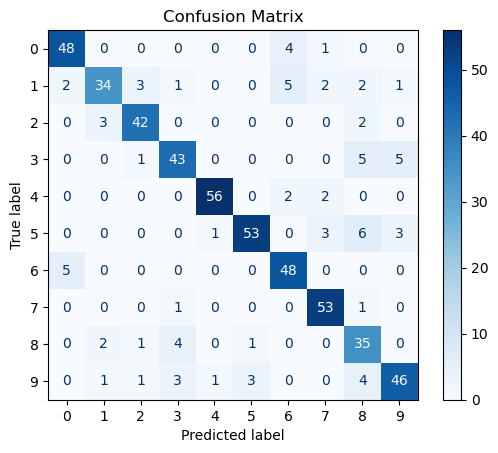

Feature Importances for DecisionTreeClassifier:
[0.31330772440880184, 0.18268809974311453, 0.12522942079187444, 0.11686967153571079, 0.100897203149503, 0.04967094026185153, 0.0470649520688461, 0.03273556191976347, 0.01448251826931592, 0.008630818920324544, 0.008423088930893618]
--------------------------------------------------------------------------------
Tuning DecisionTreeClassifier (classification) with bayesian search and scoring metric: f1_macro
Best Params: OrderedDict({'model__criterion': 'entropy', 'model__max_depth': 19, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__splitter': 'best', 'pca__n_components': 46, 'scaler__with_mean': True, 'scaler__with_std': False})
Best Score (Train): 0.8369327030416858
Test Score: 0.8331703779448754
--------------------------------------------------------------------------------
Classification Report for DecisionTreeClassifier with f1_macro:

              precision    recall  f1-score   support

           0       0.92

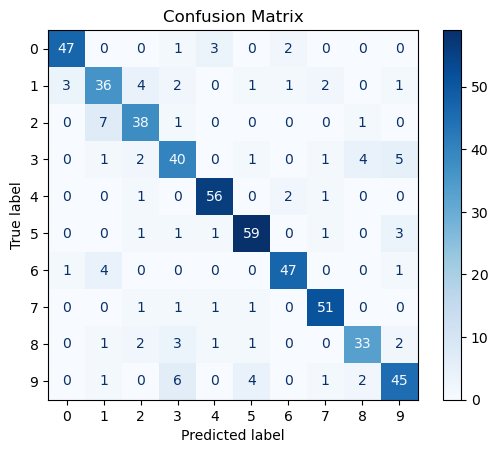

Feature Importances for DecisionTreeClassifier:
[0.2911438078070801, 0.1756818387276378, 0.115657401657795, 0.10546744150043842, 0.08452745141842295, 0.04065803917859172, 0.03700962523398134, 0.03067619298031647, 0.01192503115032683, 0.011832774785084632, 0.011261189168841041, 0.008475149160870577, 0.008302967847754649, 0.008123528279213173, 0.007819673762822376, 0.00456191389458819, 0.00444732490798604, 0.004443449361739788, 0.004165317874676516, 0.0038870578420367526, 0.003711451758238983, 0.0036456119617736906, 0.003353893575325646, 0.0025849016268406893, 0.0024716134502701585, 0.0019744265598921895, 0.0017990704385109466, 0.0017294785709212918, 0.0014373829608538488, 0.0013757563872556712, 0.0012928399856548143, 0.0009582553072358992, 0.0006599713924464986, 0.0006599713924464984, 0.0006599713924464984, 0.0006599713924464984, 0.0004791276536179496, 0.0004791276536179496, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
-------------------------------------------------------------------------

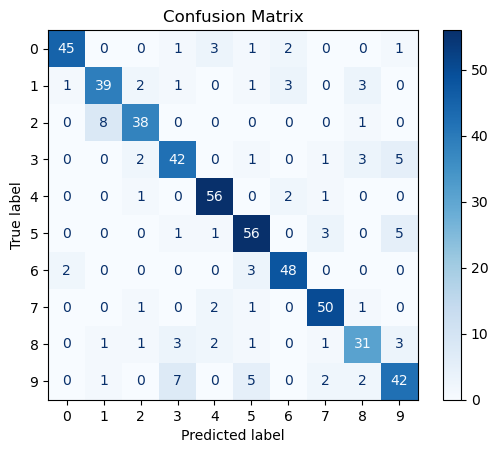

Feature Importances for DecisionTreeClassifier:
[0.28714991402120316, 0.17299410484948058, 0.11854990342896635, 0.10374688196984645, 0.09077384676491992, 0.04119301008201518, 0.03700962523398134, 0.032030201196407426, 0.011832774785084632, 0.011111856085603989, 0.01071625327702919, 0.010470647644540164, 0.008962939240201147, 0.008822562411992895, 0.007648854327963499, 0.005855923895041493, 0.005531887920550405, 0.005021368349029362, 0.003975787214873112, 0.0038808695373147946, 0.0034079301884188027, 0.0023956382680897486, 0.002395638268089748, 0.0023322347052220516, 0.0019844075307823422, 0.001694201881862808, 0.0016182266996823975, 0.001319942784892997, 0.001319942784892997, 0.001314455167445691, 0.001139099046064448, 0.0006599713924464986, 0.0006599713924464984, 0.0004791276536179496, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------------------------------------
Tuning DecisionTreeClassifier (classification) with bayesian search and scoring metric: precision_mac

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

In [ ]:
# tuner.tune_all_models('classification', 'bayesian', X_train_clf, y_train_clf, X_test_clf, y_test_clf)


### REG


In [ ]:
# X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(modelData, cleanTarget, test_size=0.3, random_state=42)
# tuner.tune_all_models('regression', 'bayesian', X_train_reg, y_train_reg, X_test_reg, y_test_reg)
